<div class='alert alert-info'>
    <b>Importing Libraries<b>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

<div class='alert alert-info'>
    <b>Importing Data & Preprocessing<b>

In [2]:
df = pd.read_excel("Immunotherapy.xlsx")
df

,sex,age,Time,Number_of_Warts,Type,Area,induration_diameter,Result_of_Treatment
0,1,22,2.25,14,3,51,50,1
1,1,15,3.00,2,3,900,70,1
2,1,16,10.50,2,1,100,25,1
3,1,27,4.50,9,3,80,30,1
4,1,20,8.00,6,1,45,8,1
...,...,...,...,...,...,...,...,...
85,1,40,5.50,8,3,69,5,1
86,1,38,7.50,8,2,56,45,1
87,1,46,11.50,4,1,91,25,0
88,1,32,12.00,9,1,43,50,0


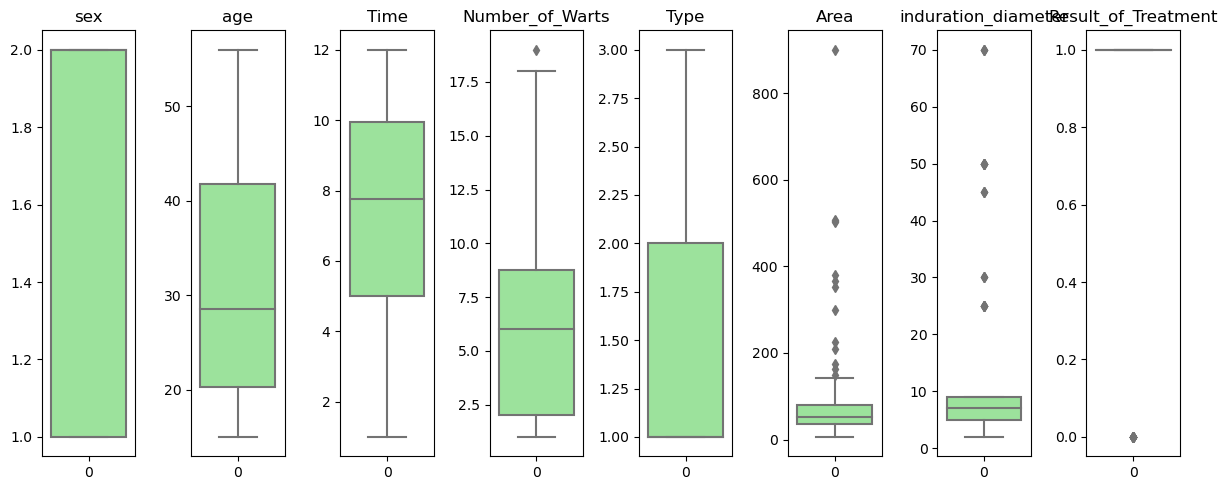

In [3]:
# outliers
collist = df.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(data = df[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

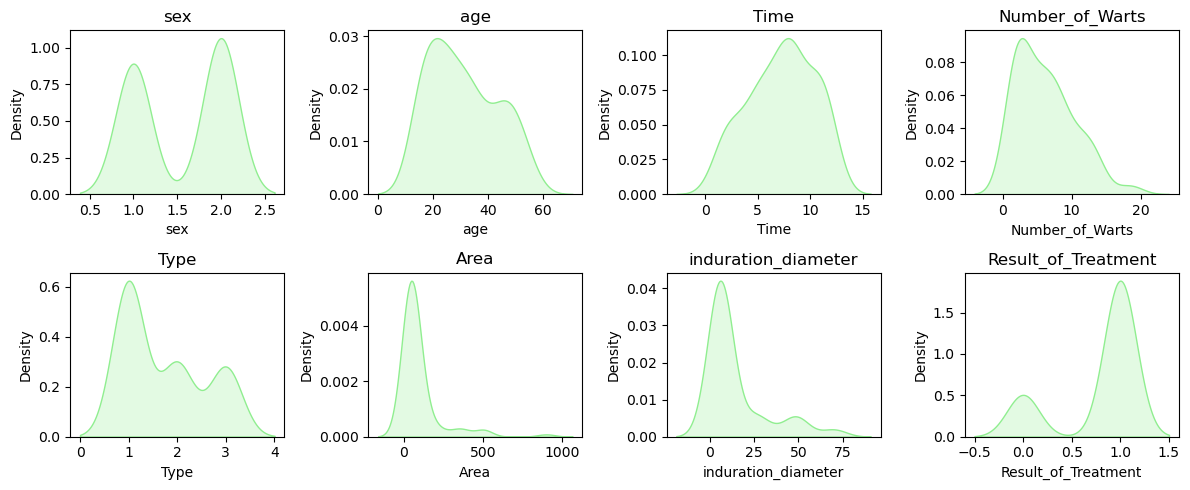

In [4]:
# skewness
collist = df.columns.values
nrows = 2
ncols = 4

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.kdeplot(df[collist[i]], fill=True, color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

In [5]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({'Columns':df.columns.values,'VIF_Factor':[variance_inflation_factor(df.values,i) for i in range(df.shape[1])]})
vif

,Columns,VIF_Factor
0,sex,8.349154
1,age,6.862018
2,Time,5.790807
3,Number_of_Warts,3.302114
4,Type,4.992490
5,Area,1.505630
6,induration_diameter,1.845174
7,Result_of_Treatment,4.222858


<div class='alert alert-info'>
    <b>Removing Outliers<b>

In [6]:
# removing outliers using zscore
from scipy.stats import zscore

z = np.abs(zscore(df))
df_new = df[(z<3).all(axis=1)]
print ("The amount of data loss (%):",(df.shape[0]-df_new.shape[0])/df.shape[0]*100,'%')

The amount of data loss (%): 6.666666666666667 %


In [7]:
# removing outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1

df_IQR = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print ("Percentage of data loss =",(df.shape[0]-df_IQR.shape[0])/df.shape[0]*100,'%')

Percentage of data loss = 48.888888888888886 %


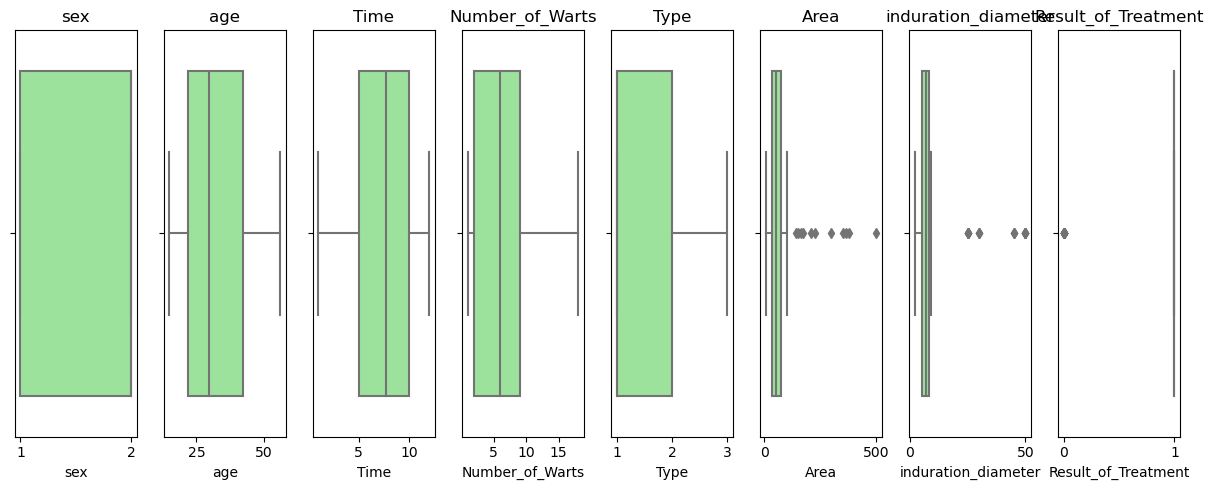

In [8]:
# outliers after zscore
collist = df_new.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(df_new[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

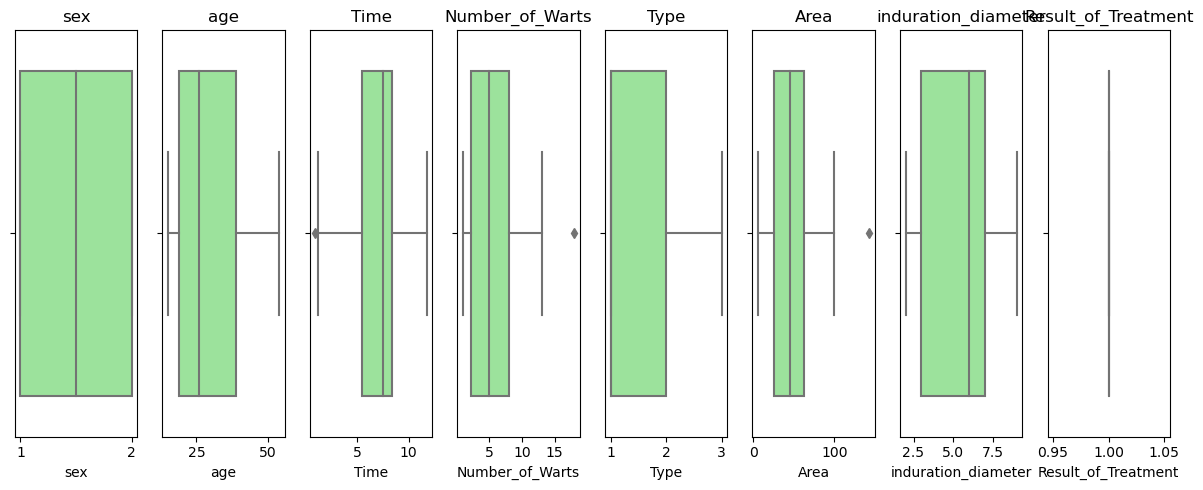

In [9]:
# outliers after IQR
collist = df_IQR.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(df_IQR[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

<div class='alert alert-info'>
    <b>Splitting into x & y<b>

In [10]:
x = df.drop('Result_of_Treatment',axis=1)
y = df.Result_of_Treatment

<div class='alert alert-info'>
    <b>Model Building<b>

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [12]:
# scaling and transforming
from sklearn.preprocessing import StandardScaler, power_transform

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test,y_pred):
    LB = LabelBinarizer()
    LB_y_test = LB.fit_transform(y_test)
    LB_y_pred = LB.fit_transform(y_pred)
    return round(roc_auc_score(LB_y_test,LB_y_pred)*100,2)

In [14]:
# making a function for classification models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

Model, score, f1, cross, roc_auc = [], [], [], [], []

def classification_model(model):
    Model.append(str(model).split("(")[0])
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    
    scoree = round(accuracy_score(y_test,y_pred)*100,2)
    score.append(scoree)
    
    f1_s = round(f1_score(y_test,y_pred,average='micro')*100,2)
    f1.append(f1_s)
    
    cross_v = cross_val_score(model,x,y,cv=10,scoring='accuracy').mean()
    cross.append(cross_v)
    
    roc_ = multiclass_roc_auc_score(y_test,y_pred)
    roc_auc.append(roc_)
    
    print ("Model:",str(model).split("(")[0])
    print ("Accuracy Score:",scoree)
    print ("f1 Score:",f1_s)
    print ("CV Score:",cross_v)
    print ("ROC_AUC Score:",roc_)

#      shows the classification report
    class_report = classification_report(y_test,model.predict(x_test))
    print (class_report)
    
    
#     shows the confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,square=True)

In [15]:
#Random Forest Classisfier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_para = {'n_estimators':range(100,600,50),'criterion':['gini','entropy','log_loss']}
gsCV_rfc = GridSearchCV(rfc,rfc_para,cv=7,scoring='accuracy')
gsCV_rfc.fit(x_train,y_train)
gsCV_rfc.best_params_

{'criterion': 'gini', 'n_estimators': 450}

Model: RandomForestClassifier
Accuracy Score: 77.78
f1 Score: 77.78
CV Score: 0.8555555555555555
ROC_AUC Score: 58.93
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.81      0.93      0.87        14

    accuracy                           0.78        18
   macro avg       0.66      0.59      0.60        18
weighted avg       0.74      0.78      0.75        18



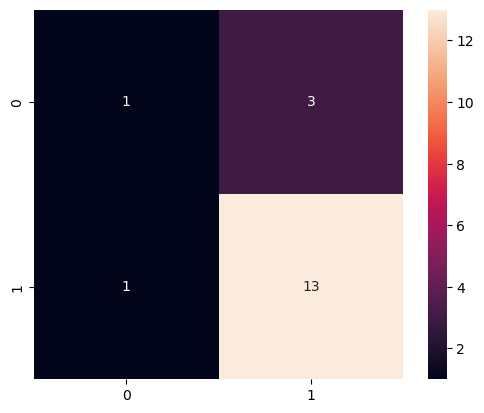

In [16]:
rfc = RandomForestClassifier(criterion='gini',n_estimators=450)
classification_model(rfc)

In [17]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc_para = {'n_estimators':range(100,600,50)}
gsCV_bc = GridSearchCV(bc,bc_para,cv=7,scoring='accuracy')
gsCV_bc.fit(x_train,y_train)
gsCV_bc.best_params_

{'n_estimators': 250}

Model: BaggingClassifier
Accuracy Score: 83.33
f1 Score: 83.33
CV Score: 0.8777777777777779
ROC_AUC Score: 71.43
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.87      0.93      0.90        14

    accuracy                           0.83        18
   macro avg       0.77      0.71      0.73        18
weighted avg       0.82      0.83      0.82        18



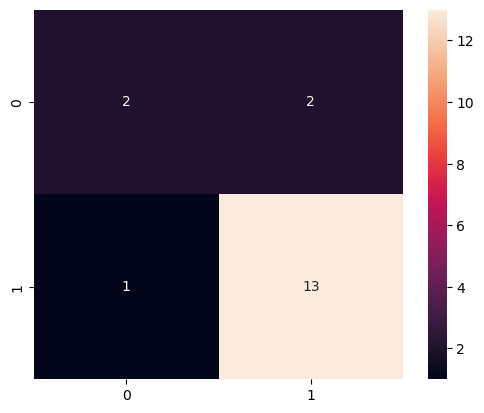

In [18]:
bc = BaggingClassifier(n_estimators=250)
classification_model(bc)

In [24]:
bc = BaggingClassifier(n_estimators=250)
bc.fit(x_train,y_train)
bc_y_pred = bc.predict(x_test)
bc_score = accuracy_score(y_test,bc_y_pred)
bc_f1_s = round(f1_score(y_test,bc_y_pred,average='micro')*100,2)
bc_cross_v = cross_val_score(bc,x,y,cv=10,scoring='accuracy').mean()
bc_roc_ = multiclass_roc_auc_score(y_test,bc_y_pred)

print ("Test Score:",round(bc_score*100,2),'%')
print ("F1 Score:",bc_f1_s,'%')
print ("bc_cross_v:",round(bc_cross_v*100,2),'%')
print ("AUC Score:",bc_roc_,'%')

Test Score: 83.33 %
F1 Score: 83.33 %
bc_cross_v: 87.78 %
AUC Score: 71.43 %


<div class='alert alert-info'>
    <b>Actual vs Predicted<b>

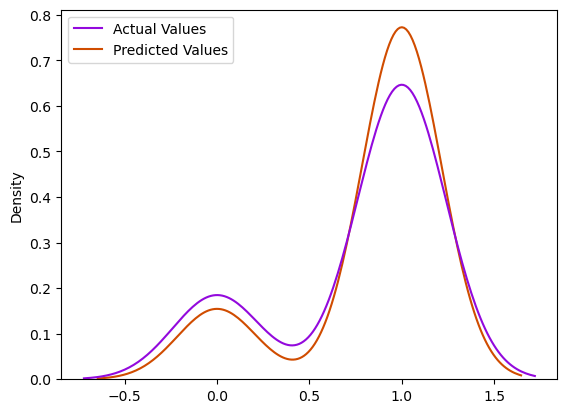

In [25]:
actualVSpredicted = pd.DataFrame({'Actual Values':y_test,'Predicted Values':bc_y_pred})
sns.kdeplot(data=actualVSpredicted,palette='gnuplot')
plt.show()

<div class='alert alert-info'>
    <b>ROC Curve and Feature Importance<b>

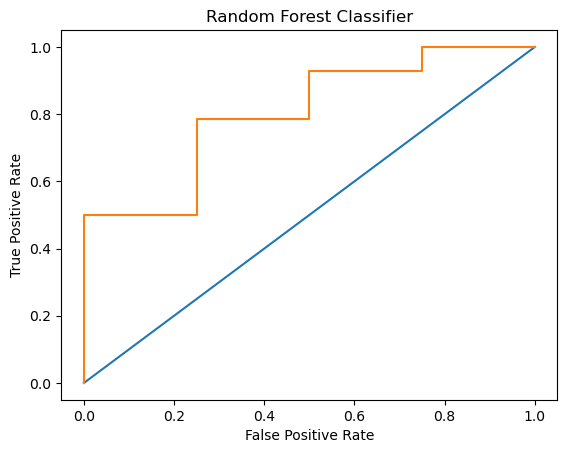

In [26]:
# Plotting ROC Curve for the model
from sklearn.metrics import roc_curve
y_pred_prob = bc.predict_proba(x_test)[:,1]  #1 is the probabilty of threshold value
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier')
plt.show()

<AxesSubplot:>

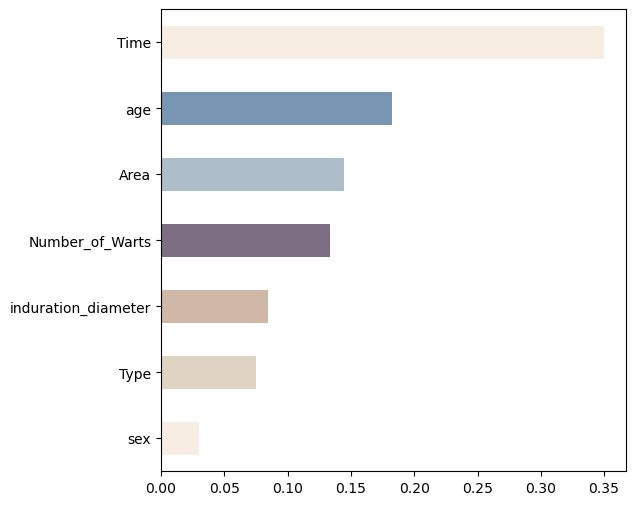

In [28]:
# Feature importance of the classifier
pd.Series(rfc.feature_importances_, index = df_new.columns[:-1]).sort_values(ascending=True).plot(kind='barh', figsize=(6,6),
                                                                                               color=(['#F8EDE3','#DFD3C3',
                                                                                                     '#D0B8A8','#7D6E83',
                                                                                                      '#AEBDCA','#7895B2']))

<div class='alert alert-info'>
    <b>Saving the model file<b>

In [29]:
import pickle
pickle.dump(bc,open('BC_immunotherapy.pkl','wb'))
pickle.dump(scaler,open('scaling.pkl','wb'))

In [34]:
new_ = {
"sex":1,
"age":22,
"Time":10.1,
"Number_of_Warts":8,
"Type":3,
"Area":69,
"induration_diameter":80
}

In [42]:
pickled_model = pickle.load(open('RFC_immunotherapy.pkl','rb'))
pickled_model.predict(scaler.transform(np.array(list(new_.values())).reshape(1, -1)))

array([1])